In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/05 02:49:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('dataset1-1/part-00000-08c7db4a-479f-4c60-9ae4-4ae109f8ec54-c000.csv', header=True)
df.describe().show()

+-------+-----------+------+---------------------+---------------------+--------------------+-----------+------------------+
|summary|    Country|Gender|Demographics Question|Demographics Response|            Question|Survey Year|             Value|
+-------+-----------+------+---------------------+---------------------+--------------------+-----------+------------------+
|  count|      11187| 11187|                11187|                11187|               11187|      11187|             11187|
|   mean|       null|  null|                 null|                 null|                null|       null| 4.005106687322341|
| stddev|       null|  null|                 null|                 null|                null|       null|1.9292459669184192|
|    min|Afghanistan|     F|                  Age|                15-24|... for at least ...| 01/01/2000|               0.0|
|    max|   Zimbabwe|     M|            Residence| Widowed, divorced...|... if she refuse...| 01/01/2018| 9.322017030979879|


In [3]:
import pandas as pd
import statsmodels.api as sm
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType,IntegerType

df = df.withColumn("Value", col("Value").cast(FloatType()))
df1 = df.toPandas()

X_dr = pd.get_dummies(df1['Demographics Response'], drop_first=True, dtype=int)

df_encoded = pd.concat([df1,X_dr], axis=1)
df_encoded.drop(['Country', 'Gender','Demographics Question','Demographics Response','Question','Survey Year'], axis=1, inplace=True)
y = df_encoded['Value']
X = df_encoded.drop('Value', axis=1)
X = sm.add_constant(X)   

model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     58.20
Date:                Thu, 05 Oct 2023   Prob (F-statistic):          7.13e-159
Time:                        02:23:47   Log-Likelihood:                -22831.
No. Observations:               11187   AIC:                         4.569e+04
Df Residuals:                   11172   BIC:                         4.580e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            4.1978      0.068     62.013      0.000       4.065       4.330
25-34                           -0.2037      0.096     -2.128      0.033      -0.391      -0.016
35-49                           -0.2421      0.096     -2.529      0.011      -0.430      -0.054
Employed for cash               -0.2012      0.096     -2.086      0.037      -0.390      -0.012
Employed for kind                0.3493      0.096      3.627      0.000       0.161       0.538
Higher                          -1.7307      0.096    -18.043      0.000      -1.919      -1.543
Married or living together      -0.1577      0.096     -1.647      0.100      -0.345       0.030
Never married                   -0.2583      0.097     -2.655      0.008      -0.449      -0.068
No education                     0.4872      0.098      4.994      0.000       0.296       0.678
Primary                          0.2195      0.097      2.269      0.023       0.030       0.409
Rural                            0.2304      0.096      2.407      0.016       0.043       0.418
Secondary                       -0.4461      0.096     -4.660      0.000      -0.634      -0.258
Unemployed                      -0.1838      0.096     -1.920      0.055      -0.371       0.004
Urban                           -0.6393      0.096     -6.678      0.000      -0.827      -0.452
Widowed, divorced, separated    -0.0516      0.096     -0.538      0.590      -0.240       0.136
==============================================================================
Omnibus:                      561.764   Durbin-Watson:                   0.374
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              345.775
Skew:                           0.298   Prob(JB):                     8.24e-76
Kurtosis:                       2.378   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
df2 = spark.read.csv('dataset3/part-00000-97be97e5-9192-457c-86ac-38f5a8a3b2aa-c000.csv', header=True)
df2.describe().show()

+-------+-----------+------------------+------+--------------------+-----------------------+
|summary|FECHA HECHO|          CANTIDAD|GENERO|         Weapon Used|Total domestic violence|
+-------+-----------+------------------+------+--------------------+-----------------------+
|  count|      56832|             56832| 56832|               56832|                  56832|
|   mean|       null|3.9417053772522523|  null|                null|      8.211553350225225|
| stddev|       null|3.6173151565087447|  null|                null|     15.789425843555712|
|    min| 2015-01-01|                 1|     F|No Weapon or Subs...|                    1.0|
|    max| 2023-02-28|                 9|     M|Using weapons and...|                   99.0|
+-------+-----------+------------------+------+--------------------+-----------------------+



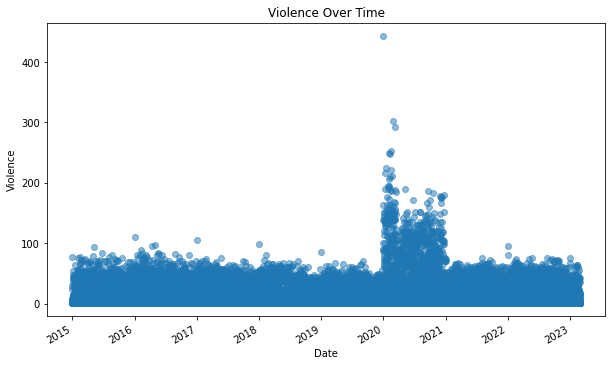

In [7]:
from pyspark.sql.types import FloatType,IntegerType
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
df2 = df2.withColumn("Total domestic violence", col("Total domestic violence").cast(IntegerType()))
df2 = df2.withColumn("FECHA HECHO", col("FECHA HECHO").cast("date"))

data = df2.select("FECHA HECHO", "Total domestic violence").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(data['FECHA HECHO'], data['Total domestic violence'], alpha=0.5)

plt.title('Violence Over Time')
plt.xlabel('Date')
plt.ylabel('Violence')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.show()


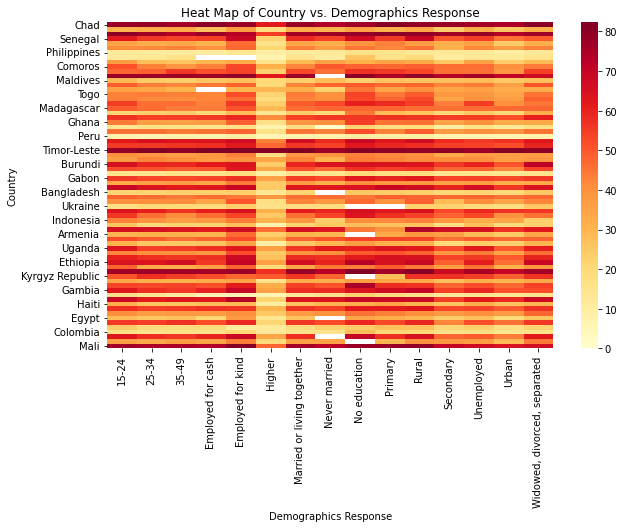

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
pivot_df = df.groupBy("Country").pivot("Demographics Response").sum("value")
pivot_df = pivot_df.toPandas()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df.set_index("Country"), annot=False, cmap="YlOrRd")
plt.title("Heat Map of Country vs. Demographics Response")
plt.xlabel("Demographics Response")
plt.ylabel("Country")
plt.show()

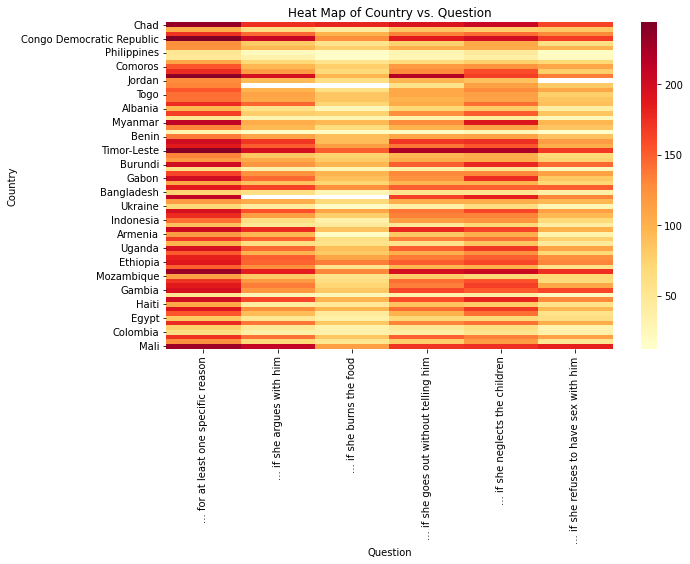

In [8]:
pivot_df = df.groupBy("Country").pivot("Question").sum("value")
pivot_df = pivot_df.toPandas()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df.set_index("Country"), annot=False, cmap="YlOrRd")
plt.title("Heat Map of Country vs. Question")
plt.xlabel("Question")
plt.ylabel("Country")
plt.show()

In [12]:
df3 = spark.read.csv('dataset4/part-00000-e8fbff2b-4af5-4659-8ee9-feb16b3e44b4-c000.csv', header=True)
df3.describe().show()

+-------+-----------+------+------------------+-------------------+--------------------+
|summary|FECHA HECHO|GENERO|          CANTIDAD|    FECHA HECHO_STR|         Weapon Used|
+-------+-----------+------+------------------+-------------------+--------------------+
|  count|     466679|466679|            466679|             466679|              466679|
|   mean|       null|  null|1.5416313997415783|               null|                null|
| stddev|       null|  null|1.6656822733680472|               null|                null|
|    min| 2015-01-01|     F|                 1|2015-01-01 00:00:00|No Weapon or Subs...|
|    max| 2023-02-28|     M|                 9|2023-02-28 00:00:00|Using weapons and...|
+-------+-----------+------+------------------+-------------------+--------------------+



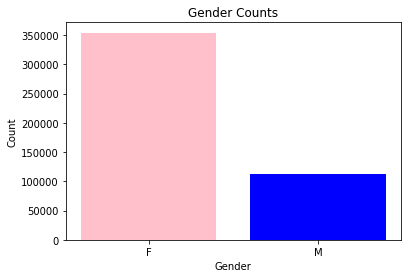

In [13]:

gender_counts = df3.groupBy("GENERO").count().orderBy("GENERO")
gender_counts_pd = gender_counts.toPandas()
plt.figure(figsize=(6, 4))
plt.bar(gender_counts_pd["GENERO"], gender_counts_pd["count"], color=['pink', 'blue'])
plt.title("Gender Counts")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

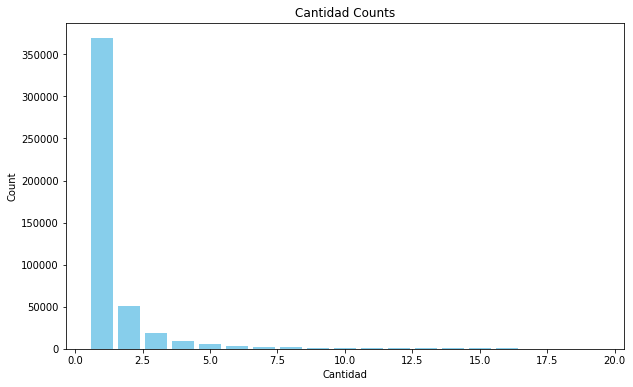

In [14]:
cantidad_counts = df3.groupBy("CANTIDAD").count().orderBy("CANTIDAD")
cantidad_counts_pd = cantidad_counts.toPandas()
cantidad_counts_pd["CANTIDAD"] = cantidad_counts_pd["CANTIDAD"].astype(int)
plt.figure(figsize=(10, 6))
plt.bar(cantidad_counts_pd["CANTIDAD"], cantidad_counts_pd["count"], color='skyblue')
plt.title("Cantidad Counts")
plt.xlabel("Cantidad")
plt.ylabel("Count")
plt.show()

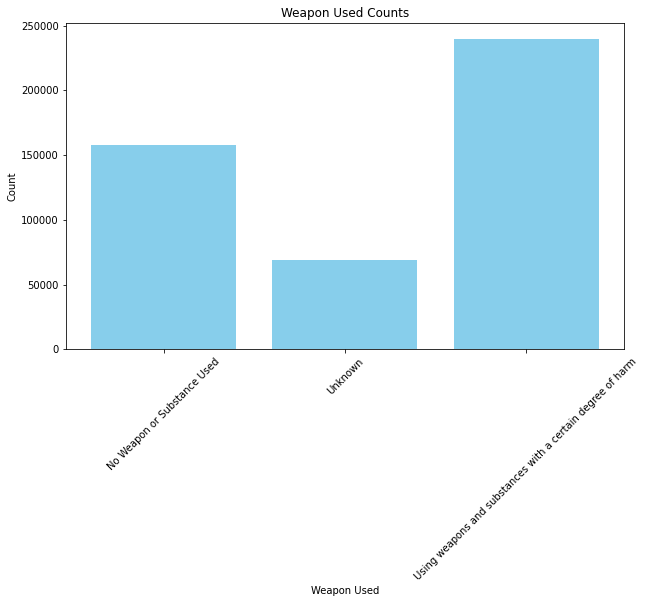

In [15]:
weapon_used_counts = df3.groupBy("Weapon Used").count().orderBy("Weapon Used")

weapon_used_counts_pd = weapon_used_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(weapon_used_counts_pd["Weapon Used"], weapon_used_counts_pd["count"], color='skyblue')
plt.title("Weapon Used Counts")
plt.xlabel("Weapon Used")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()